# Cryptocurrency Time Series Forecasting Using XGBoost

# Brief introduction of XGBoost

### XGBoost stands for "Extreme Gradient Boosting". XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It implements Machine Learning algorithms under the Gradient Boosting framework. it provides a parallel tree boosting to solve many data science problems in a fast and accurate way.

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

# Import Dataset

In [2]:
bitcoindf = pd.read_csv('../data/Bitcoin/BTC-USD-NEW.csv')
bitcoindf = bitcoindf[bitcoindf.columns[1:]]
bitcoindf.head()

,date,open,high,low,close,adj_close,volume
0,2015-09-13,235.242004,235.934998,229.332001,230.511993,230.511993,18478800.0
1,2015-09-14,230.608994,232.440002,227.960999,230.643997,230.643997,20997800.0
2,2015-09-15,230.492004,259.182007,229.822006,230.304001,230.304001,19177800.0
3,2015-09-16,230.250000,231.214996,227.401993,229.091003,229.091003,20144200.0
4,2015-09-17,229.076004,230.285004,228.925995,229.809998,229.809998,18935400.0


In [3]:
cardanodf = pd.read_csv('../data/Cardano/ADA-USD-NEW.csv')
cardanodf = cardanodf[cardanodf.columns[1:]]
cardanodf.head()

,date,open,high,low,close,adj_close,volume
0,2017-10-01,0.021678,0.032226,0.017354,0.024969,0.024969,50068700.0
1,2017-10-02,0.024607,0.030088,0.019969,0.025932,0.025932,57641300.0
2,2017-10-03,0.025757,0.027425,0.020690,0.020816,0.020816,16997800.0
3,2017-10-04,0.020864,0.022806,0.020864,0.021931,0.021931,9000050.0
4,2017-10-05,0.021951,0.022154,0.020859,0.021489,0.021489,5562510.0


In [4]:
dogecoindf = pd.read_csv('../data/Dogecoin/DOGE-USD-NEW.csv')
dogecoindf = dogecoindf[dogecoindf.columns[1:]]
dogecoindf.head()

,date,open,high,low,close,adj_close,volume
0,2015-09-13,0.000127,0.000129,0.000123,0.000126,0.000126,40889.0
1,2015-09-14,0.000125,0.000126,0.000122,0.000125,0.000125,61189.0
2,2015-09-15,0.000125,0.000131,0.000123,0.000126,0.000126,43332.0
3,2015-09-16,0.000126,0.000126,0.000122,0.000124,0.000124,60323.0
4,2015-09-17,0.000124,0.000126,0.000122,0.000125,0.000125,60512.0


In [5]:
ethereumdf = pd.read_csv('../data/Ethereum/ETH-USD-NEW.csv')
ethereumdf = ethereumdf[ethereumdf.columns[1:]]
ethereumdf.head()

,date,open,high,low,close,adj_close,volume
0,2015-09-13,1.041780,1.042700,0.902832,0.936003,0.936003,644138.0
1,2015-09-14,0.940566,0.949387,0.871760,0.875622,0.875622,741085.0
2,2015-09-15,0.875189,1.045540,0.875189,0.944410,0.944410,703390.0
3,2015-09-16,0.941977,0.952698,0.901639,0.907175,0.907175,615593.0
4,2015-09-17,0.906865,0.909204,0.831132,0.874231,0.874231,897940.0


# Bitcoin Close Price Prediction using XGBoost

##### Dataframe of bitcoin close price

In [6]:
closedf = bitcoindf[['date', 'close']]
print('Shape of close dataframe: ', closedf.shape)

Shape of close dataframe:  (2193, 2)


In [7]:
closedf = closedf[closedf['date'] > '2020-09-13']
close_stock = closedf.copy()
print('Total date for prediction: ', closedf.shape[0])

Total date for prediction:  365


##### Normalizing close price value

In [8]:
del closedf['date']
scaler = MinMaxScaler(feature_range = (0, 1))
closedf = scaler.fit_transform(np.array(closedf).reshape(-1, 1))
print(closedf.shape)

(365, 1)


##### Separate data for Train and Test

In [9]:
training_size = int(len(closedf) * 0.70)
test_size = len(closedf) - training_size
train_data, test_data = closedf[0 : training_size, :], closedf[training_size : len(closedf), :1]
print('train_data: ', train_data.shape)
print('test_data: ',test_data.shape)

train_data:  (255, 1)
test_data:  (110, 1)


/var/folders/g9/s15kjggj0bb9t_61f58dny800000gn/T/ipykernel_93873/1584028624.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.lineplot(x = close_stock['date'][:255], y = close_stock['close'][:255], color = 'black')
/var/folders/g9/s15kjggj0bb9t_61f58dny800000gn/T/ipykernel_93873/1584028624.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.lineplot(x = close_stock['date'][255:], y = close_stock['close'][255:], color = 'red')


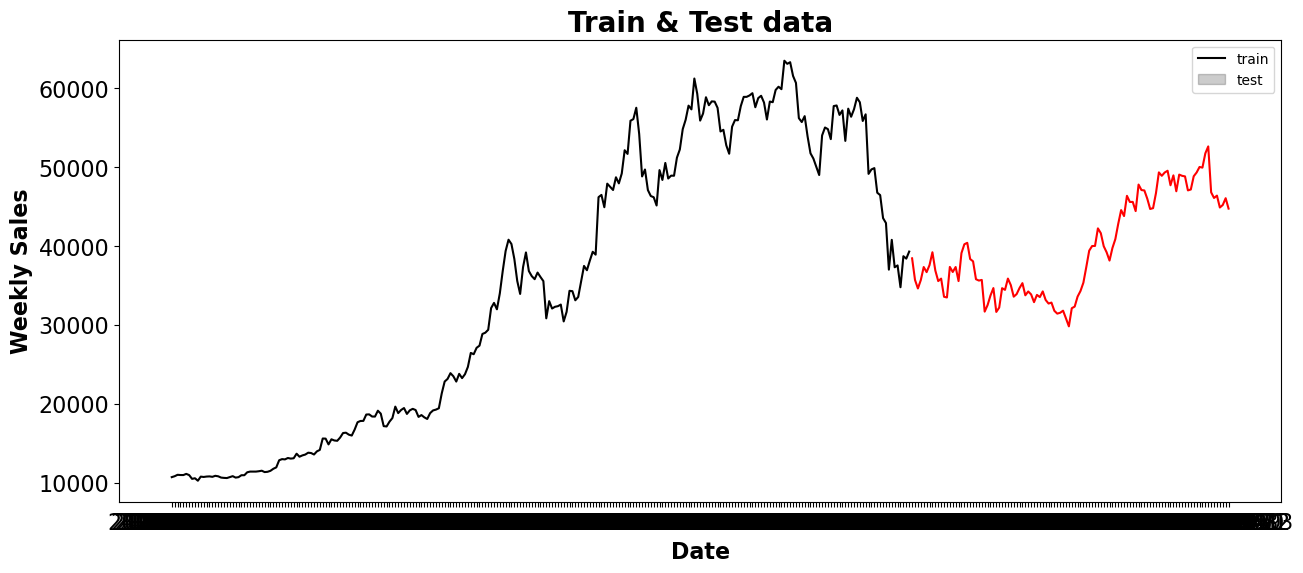

In [10]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.lineplot(x = close_stock['date'][:255], y = close_stock['close'][:255], color = 'black')
sns.lineplot(x = close_stock['date'][255:], y = close_stock['close'][255:], color = 'red')

# Formatting 
ax.set_title('Train & Test data', fontsize = 20, loc = 'center', fontdict = dict(weight = 'bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict = dict(weight = 'bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict = dict(weight = 'bold'))
plt.tick_params(axis = 'y', which = 'major', labelsize = 16)
plt.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.legend(loc = 'upper right', labels = ('train', 'test'))

##### Prepare train data for time series analysis

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i : (i + time_step), 0] ### i = 0, 0, 1, 2, 3-----99 100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (239, 15)
y_train:  (239,)
X_test:  (94, 15)
y_test:  (94,)


##### Import XGBRegressor module and Fit X_train and Y_train for training model

In [13]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators = 1000)
my_model.fit(X_train, y_train, verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

##### Model testing and evaluation

In [14]:
predictions = my_model.predict(X_test)
print('Mean Absolute Error - MAE : ' + str(mean_absolute_error(y_test, predictions)))
print('Root Mean Squared Error - RMSE : ' + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.02658387822445798
Root Mean Squared Error - RMSE : 0.03641535799501778


In [15]:
train_predict = my_model.predict(X_train)
test_predict = my_model.predict(X_test)

train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

print('Train data prediction: ', train_predict.shape)
print('Test data prediction: ', test_predict.shape)

Train data prediction:  (239, 1)
Test data prediction:  (94, 1)


In [16]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))

In [17]:
# shift train predictions for plotting

look_back = time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(train_predict) + look_back, :] = train_predict
print('Train predicted data: ', trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1 : len(closedf) - 1, :] = test_predict
print('Test predicted data: ', testPredictPlot.shape)

names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'], 'original_close': close_stock['close'], 'train_predicted_close': trainPredictPlot.reshape(1, -1)[0].tolist(), 'test_predicted_close' : testPredictPlot.reshape(1, -1)[0].tolist()})

fig = px.line(plotdf, x = plotdf['date'], y = [plotdf['original_close'], plotdf['train_predicted_close'], plotdf['test_predicted_close']], labels = {'value': 'Close price', 'date': 'Date'})
fig.update_layout(title_text = 'Comparison between original close price vs predicted close price', plot_bgcolor = 'white', font_size = 15, font_color = 'black', legend_title_text = 'Close Price')
fig.for_each_trace(lambda t: t.update(name = next(names)))

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


##### Prediction next 10 days

In [18]:
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 10
while (i < pred_days):

    if (len(temp_input) > time_step):

        x_input = np.array(temp_input[1:])
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)

        yhat = my_model.predict(x_input)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i = i + 1

    else:
        yhat = my_model.predict(x_input)

        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())

        i = i + 1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [19]:
last_days = np.arange(1, time_step + 1)
day_pred = np.arange(time_step + 1, time_step + pred_days + 1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [20]:
temp_mat = np.empty((len(last_days) + pred_days + 1, 1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1, -1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0 : time_step + 1] = scaler.inverse_transform(closedf[len(closedf) - time_step :]).reshape(1, -1).tolist()[0]
next_predicted_days_value[time_step + 1 :] = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).reshape(1, -1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value': last_original_days_value,
    'next_predicted_days_value': next_predicted_days_value
})

names = cycle(['Last 15 days close price', 'Predicted next 10 days close price'])

fig = px.line(new_pred_plot, x = new_pred_plot.index, y = [new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']], labels = {'value': 'Close price', 'index': 'Timestamp'})
fig.update_layout(title_text = 'Compare last 15 days vs next 10 days', plot_bgcolor = 'white', font_size = 15, font_color = 'black', legend_title_text = 'Close Price')
fig.for_each_trace(lambda t: t.update(name = next(names)))
fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.show()

In [21]:
my_model = closedf.tolist()
my_model.extend((np.array(lst_output).reshape(-1, 1)).tolist())
my_model = scaler.inverse_transform(my_model).reshape(1, -1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(my_model, labels = {'value': 'Close price', 'index': 'Timestamp'})
fig.update_layout(title_text = 'Plotting whole closing price with prediction', plot_bgcolor = 'white', font_size = 15, font_color = 'black', legend_title_text = 'Stock')
fig.for_each_trace(lambda t: t.update(name = next(names)))
fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.show()